In [1]:
import os
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
import gc

edge_difffile = "G:/Hangkai/Forest_edge_mapping_data/Global_001_degree/2020Edge.tif"
area_difffile = "G:/Hangkai/Forest_edge_mapping_data/Global_001_degree/2020Area.tif"


with rasterio.open(area_difffile) as src:
    area_data = src.read(1)  # Read the first band
    transform = src.transform
    crs = src.crs

    # Mask out no-data values if necessary
    nodata = src.nodata
    if nodata is not None:
        area_data[area_data == nodata] = 0
    area_data = area_data/(1000*1000)
    
with rasterio.open(edge_difffile) as src:
    edge_data = src.read(1)  # Read the first band
    transform = src.transform
    crs = src.crs
    
    # Mask out no-data values if necessary
    nodata = src.nodata
    if nodata is not None:
        edge_data[edge_data == nodata] = 0
    edge_data = edge_data/1000

del src
gc.collect()

C:\Users\hyou34\AppData\Local\miniconda3\envs\py39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\hyou34\AppData\Local\miniconda3\envs\py39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\Users\hyou34\AppData\Local\miniconda3\envs\py39\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


0

In [2]:
area_lower = np.nanmin(area_data)
area_upper = np.nanmax(area_data)

edge_lower = np.nanmin(edge_data)
edge_upper = np.nanmax(edge_data)

print(area_lower)
print(area_upper)
print(edge_lower)
print(edge_upper)

0.0
1.2392
0.0
36.0045


In [3]:
area_lower = 0
area_upper = 1
edge_lower = 0
edge_upper = 20

print(area_lower)
print(area_upper)
print(edge_lower)
print(edge_upper)

area_data[area_data < area_lower] = area_lower
area_data[area_data > area_upper] = area_upper
edge_data[edge_data < edge_lower] = edge_lower
edge_data[edge_data > edge_upper] = edge_upper

mask = (area_data >0)

print(np.nanmax(edge_data))
print(np.nanmin(edge_data))
print(np.nanmax(area_data))
print(np.nanmin(area_data))

area_diff_clipped = np.clip(area_data, area_lower, area_upper)
edge_diff_clipped = np.clip(edge_data, edge_lower, edge_upper)

del area_data, edge_data,
gc.collect()

area_diff_norm = (area_diff_clipped + area_upper) / (2*area_upper)
del area_diff_clipped
gc.collect()

edge_diff_norm = (edge_diff_clipped + edge_upper) / (2*edge_upper)

del edge_diff_clipped
gc.collect()

# Compute the indices for your colormap
n = 40  # Number of steps (same as before)
area_indices = (area_diff_norm * (n - 1)).astype(int)
del area_diff_norm
gc.collect()
edge_indices = (edge_diff_norm * (n - 1)).astype(int)
del edge_diff_norm
gc.collect()

0
1
0
20
20.0
0.0
1.0
0.0


0

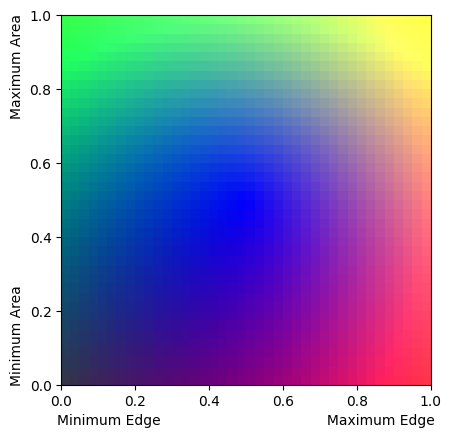

100%|████████████████████████████████████████████████████████████████████████████| 14000/14000 [08:18<00:00, 28.09it/s]

[-180.0, 180.0, -60.0, 80.0]


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
def custom_colormap(i, j, n):
    # Normalize the indices to the range [0, 1]
    x = i / (n - 1)
    y = j / (n - 1)
    
    # Compute the distance from the center
    distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
    
    # Define the color components based on distance from center
    g = np.clip(distance + (x - 0.5), 0, 1)
    r = np.clip(distance + (y - 0.5), 0, 1)
    b = np.clip(1 - distance, 0, 1)
    
    return (r, g, b, 1)

# Create an array representing the custom colormap
bivariate_colors = np.empty((n, n, 4))  # Initialize an empty array to store RGBA values

# Loop over each position in the array
for i in range(n):
    for j in range(n):
        bivariate_colors[i, j] = custom_colormap(i, j, n)

# Display the bivariate color scheme
plt.imshow(bivariate_colors, origin='lower', extent=[0, 1, 0, 1])
plt.xlabel('Minimum Edge                                      Maximum Edge')
plt.ylabel('Minimum Area                                      Maximum Area')
plt.show()


# Create an empty array to store the RGB values
color_array = np.zeros((*edge_indices.shape, 4), dtype=np.float32)

# Assign colors from your custom colormap
for x in tqdm(range(edge_indices.shape[0])):
    for y in range(edge_indices.shape[1]):
        if mask[x, y]:
            i = area_indices[x, y]
            j = edge_indices[x, y]
            color_array[x, y] = bivariate_colors[i, j]
        else:
            color_array[x, y] = [1.0,1.0,1.0,1.0]

left, bottom = transform * (0, edge_indices.shape[0])
right, top = transform * (edge_indices.shape[1], 0)

extent = [left, right, bottom, top]
print(extent)

In [5]:
import rasterio
from rasterio.transform import from_origin

# Update the transformation to account for the number of bands (color channels)
transform = from_origin(transform[2], transform[5], transform[0], transform[4])

color_array_file = 'G:/Hangkai/Global forest edge/001degree/2020_Edge_vs_Area.tif'

# Save color_array as a TIFF file
with rasterio.open(
    color_array_file,
    'w',
    driver='GTiff',
    height=color_array.shape[0],
    width=color_array.shape[1],
    count=4,  # color_array has 4 bands (RGBA)
    dtype=color_array.dtype,
    crs=crs,
    transform=transform
) as dst:
    for k in range(color_array.shape[2]):
        dst.write(color_array[:, :, k], k + 1)

In [6]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import numpy as np
import cartopy.feature as cfeature
import rasterio
import gc

"""
color_array_file = 'G:/Hangkai/Global forest edge/001degree/2020_Edge_vs_Area.tif'

with rasterio.open(color_array_file) as src:
    red_band = src.read(1)  # 读取红色通道
    green_band = src.read(2)  # 读取绿色通道
    blue_band = src.read(3)  # 读取蓝色通道
    alpha_band = src.read(4)  # 读取透明通道（alpha通道）

color_array = np.stack((red_band, green_band, blue_band, alpha_band), axis=-1)
del red_band, green_band,blue_band,alpha_band

color_array_float32 = np.array(color_array, dtype=np.float32)
del color_array
gc.collect()
"""

"\ncolor_array_file = 'G:/Hangkai/Global forest edge/001degree/2020_Edge_vs_Area.tif'\n\nwith rasterio.open(color_array_file) as src:\n    red_band = src.read(1)  # 读取红色通道\n    green_band = src.read(2)  # 读取绿色通道\n    blue_band = src.read(3)  # 读取蓝色通道\n    alpha_band = src.read(4)  # 读取透明通道（alpha通道）\n\ncolor_array = np.stack((red_band, green_band, blue_band, alpha_band), axis=-1)\ndel red_band, green_band,blue_band,alpha_band\n\ncolor_array_float32 = np.array(color_array, dtype=np.float32)\ndel color_array\ngc.collect()\n"

Start to plot
Almost finished


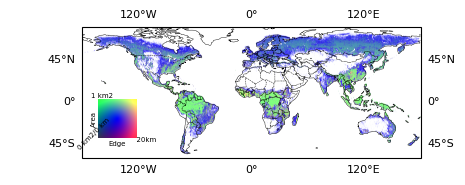

In [7]:
import matplotlib.pyplot as plt
from matplotlib import gridspec
n = 40
def custom_colormap(i, j, n):
    # Normalize the indices to the range [0, 1]
    x = i / (n - 1)
    y = j / (n - 1)
    
    # Compute the distance from the center
    distance = np.sqrt((x - 0.5)**2 + (y - 0.5)**2)
    
    # Define the color components based on distance from center
    g = np.clip(distance + (x - 0.5), 0, 1)
    r = np.clip(distance + (y - 0.5), 0, 1)
    b = np.clip(1 - distance, 0, 1)
    
    return (r, g, b, 1)

# Create an array representing the custom colormap
bivariate_colors = np.empty((n, n, 4))  # Initialize an empty array to store RGBA values

# Loop over each position in the array
for i in range(n):
    for j in range(n):
        bivariate_colors[i, j] = custom_colormap(i, j, n)
        
extent = [-180.0, 180.0, -60.0, 80.0]
plt.figure(dpi=100)

print("Start to plot")

# Create a GridSpec object
gs = gridspec.GridSpec(1, 2, width_ratios=[3, 1])

#
ax_map = plt.subplot(gs[0], projection=ccrs.PlateCarree())
ax_map.imshow(color_array, extent=extent, transform=ccrs.PlateCarree())

print("Almost finished")

ax_map.coastlines(linewidth=0.3)
# ax_map.set_title('Edge Dynamic', fontsize=10)
ax_map.tick_params(labelsize=15)
gl = ax_map.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, 
                      linewidth=0, color='gray', alpha=0.5, 
                      xlocs=[-120, 0, 120],  # Adjust for desired longitude spacing
                      ylocs=[-90, -45, 0, 45, 90])
countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_boundary_lines_land',
    scale='10m',
    facecolor='none')

ax_map.add_feature(countries, edgecolor='black', linestyle='--', linewidth = 0.3)

labels = gl.xlabel_style
labels['size'] = 8  # Change to desired size.
gl.xlabel_style = labels
labels = gl.ylabel_style
labels['size'] = 8  # Change to desired size.
gl.ylabel_style = labels

# Create Axes objects for color mapping
cmap_position = [0.14, 0.4, 0.08, 0.08]  # Adjust these values to position ax_cmap as desired

ax_cmap = plt.gcf().add_axes(cmap_position)
cmap_image = ax_cmap.imshow(bivariate_colors, origin='lower', extent=[0, 1, 0, 1])

camp_font_size = 5
ax_cmap.axis('off')
ax_cmap.text(0.5, -0.3, '0 km2/0 km                              ',
             fontsize=camp_font_size, ha='center', transform=ax_cmap.transAxes, rotation=45)
ax_cmap.text(0.5, -0.2, 'Edge', fontsize=camp_font_size, ha='center', transform=ax_cmap.transAxes)
ax_cmap.text(0.5, -0.1, '                          20km', fontsize=camp_font_size, ha='center',
             transform=ax_cmap.transAxes)
ax_cmap.text(-2.3, 1.1, '                                    1 km2', fontsize=camp_font_size, va='center',
            transform=ax_cmap.transAxes)
ax_cmap.text(-0.2, 0.5, 'Area', fontsize=camp_font_size, va='center', rotation='vertical', transform=ax_cmap.transAxes)

# plt.show()
plt.savefig('2020_Edge_vs_Area_rgb.tif', format='tiff', dpi=500)